In [12]:
!pip uninstall -y protobuf
!pip install protobuf==3.20.3

Found existing installation: protobuf 6.33.0
Uninstalling protobuf-6.33.0:
  Successfully uninstalled protobuf-6.33.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 4.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
opentelemetry-proto 1.37.0 requires protobuf<7.0,>=5.0, but you have protobuf 3.20.3 which is incompatible.
onnx 1.18.0 requires protobuf>=4.25.1, but you have protobuf 3.20.3 which is incompatible.
a2a-sdk 0.3.10 requires protobuf>=5.29.5, but you have protobuf 3.20.3 which is incompatible.
ray 2.51.1 requires click!=8.3.0,>=7.0, but you have click 8.3.0 which is incompatible.
bigframes 2.12.0 requires rich<14,>=12.4.4, but you have rich 14.2.0 which is incompatible.
tensorflow-metadata 1.17.2 requires protobuf>=4.25.2; pyth

In [13]:
import tensorflow as tf
print(tf.__version__)

2025-12-15 20:09:01.536655: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765829341.715428      20 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765829341.769733      20 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


2.18.0


In [14]:
import os
from pathlib import Path
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications.resnet_v2 import preprocess_input
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

In [15]:
# -----------------------------
# 1. Prepare dataset
# -----------------------------
RAW_ROOT = Path("/kaggle/input/multi-cancer")
IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"}

def collect_leaf_dirs(root: Path):
    subclass_to_files = {}
    for r, dirs, files in os.walk(root):
        if not files:
            continue
        rpath = Path(r)
        img_files = [str(rpath / f) for f in files if Path(f).suffix.lower() in IMG_EXTS]
        if img_files:
            class_name = rpath.name
            subclass_to_files.setdefault(class_name, []).extend(img_files)
    return subclass_to_files

subclass_to_files = collect_leaf_dirs(RAW_ROOT)
class_names = sorted(subclass_to_files.keys())
class_to_idx = {c: i for i, c in enumerate(class_names)}

# Split dataset
RATIOS = (0.7, 0.15, 0.15)
train_paths, val_paths, test_paths = [], [], []
train_labels, val_labels, test_labels = [], [], []

for cls, paths in subclass_to_files.items():
    paths = list(paths)
    random.shuffle(paths)
    n = len(paths)
    n_tr  = int(RATIOS[0] * n)
    n_val = int(RATIOS[1] * n)
    n_te  = n - n_tr - n_val
    idx = class_to_idx[cls]

    train_paths += paths[:n_tr]
    val_paths   += paths[n_tr:n_tr+n_val]
    test_paths  += paths[n_tr+n_val:]

    train_labels += [idx]*n_tr
    val_labels   += [idx]*n_val
    test_labels  += [idx]*n_te

train_paths = np.array(train_paths)
val_paths   = np.array(val_paths)
test_paths  = np.array(test_paths)
train_labels = np.array(train_labels, dtype=np.int32)
val_labels   = np.array(val_labels, dtype=np.int32)
test_labels  = np.array(test_labels, dtype=np.int32)

print(len(train_paths), len(val_paths), len(test_paths))
print(train_paths[:5])  # check first 5 paths


91000 19500 19502
['/kaggle/input/multi-cancer/Multi Cancer/Multi Cancer/Cervical Cancer/cervix_koc/cervix_koc_0273.jpg'
 '/kaggle/input/multi-cancer/Multi Cancer/Multi Cancer/Cervical Cancer/cervix_koc/cervix_koc_4171.jpg'
 '/kaggle/input/multi-cancer/Multi Cancer/Multi Cancer/Cervical Cancer/cervix_koc/cervix_koc_2906.jpg'
 '/kaggle/input/multi-cancer/Multi Cancer/Multi Cancer/Cervical Cancer/cervix_koc/cervix_koc_0624.jpg'
 '/kaggle/input/multi-cancer/Multi Cancer/Multi Cancer/Cervical Cancer/cervix_koc/cervix_koc_0448.jpg']


In [16]:
# -----------------------------
# 2. TF Dataset
# -----------------------------
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

def preprocess(path, label):
    # Ensure path is string tensor
    path = tf.cast(path, tf.string)
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32)
    img = preprocess_input(img)
    return img, label

def make_dataset(paths, labels, training=True):
    paths = np.array(paths, dtype=str)  # ensure np.array of strings
    labels = np.array(labels, dtype=np.int32)
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    if training and len(paths) > 1:
        ds = ds.shuffle(len(paths), reshuffle_each_iteration=True)
    ds = ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds


train_ds = make_dataset(train_paths, train_labels, training=True)
val_ds   = make_dataset(val_paths, val_labels, training=False)
test_ds  = make_dataset(test_paths, test_labels, training=False)

I0000 00:00:1765829480.135204      20 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [17]:
# -----------------------------
# 3. Build model (Functional API)
# -----------------------------
inputs = layers.Input(shape=(224, 224, 3))
backbone = ResNet50V2(include_top=False, weights="imagenet", input_tensor=inputs)
backbone.trainable = False

x = layers.GlobalAveragePooling2D()(backbone.output)
# x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(len(class_names), activation='softmax')(x)

model = models.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# model.summary()

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [18]:
# -----------------------------
# 4. Train
# -----------------------------
import json

history = model.fit(train_ds, validation_data=val_ds, epochs=10)

# Save only the metrics
with open("history.json", "w") as f:
    json.dump(history.history, f)

Epoch 1/10


I0000 00:00:1765829492.132436      69 service.cc:148] XLA service 0x78e5dc003d00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1765829492.133148      69 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1765829493.385679      69 cuda_dnn.cc:529] Loaded cuDNN version 90300


   3/2844 ━━━━━━━━━━━━━━━━━━━━ 1:56 41ms/step - accuracy: 0.0122 - loss: 3.6436       

I0000 00:00:1765829497.703258      69 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2844/2844 ━━━━━━━━━━━━━━━━━━━━ 238s 79ms/step - accuracy: 0.8361 - loss: 0.4853 - val_accuracy: 0.9380 - val_loss: 0.1707
Epoch 2/10
2844/2844 ━━━━━━━━━━━━━━━━━━━━ 138s 48ms/step - accuracy: 0.9456 - loss: 0.1483 - val_accuracy: 0.9501 - val_loss: 0.1406
Epoch 3/10
2844/2844 ━━━━━━━━━━━━━━━━━━━━ 138s 48ms/step - accuracy: 0.9600 - loss: 0.1095 - val_accuracy: 0.9502 - val_loss: 0.1333
Epoch 4/10
2844/2844 ━━━━━━━━━━━━━━━━━━━━ 138s 48ms/step - accuracy: 0.9669 - loss: 0.0903 - val_accuracy: 0.9571 - val_loss: 0.1190
Epoch 5/10
2844/2844 ━━━━━━━━━━━━━━━━━━━━ 138s 48ms/step - accuracy: 0.9713 - loss: 0.0773 - val_accuracy: 0.9579 - val_loss: 0.1200
Epoch 6/10
2844/2844 ━━━━━━━━━━━━━━━━━━━━ 138s 49ms/step - accuracy: 0.9739 - loss: 0.0713 - val_accuracy: 0.9593 - val_loss: 0.1150
Epoch 7/10
2844/2844 ━━━━━━━━━━━━━━━━━━━━ 138s 49ms/step - accuracy: 0.9766 - loss: 0.0634 - val_accuracy: 0.9580 - val_loss: 0.1187
Epoch 8/10
2844/2844 ━━━━━━━━━━━━━━━━━━━━ 138s 48ms/step - accuracy: 0.9786 - lo

610/610 ━━━━━━━━━━━━━━━━━━━━ 41s 67ms/step - accuracy: 0.9727 - loss: 0.0779
Test Loss: 0.1129
Test Acc : 0.9591
Macro F1   : 0.9590
Weighted F1: 0.9590
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       750
           1       0.99      0.99      0.99       750
           2       0.99      1.00      0.99       750
           3       1.00      1.00      1.00       750
           4       0.95      1.00      0.97       750
           5       0.98      0.92      0.94       750
           6       0.97      0.98      0.97       750
           7       0.97      0.95      0.96       750
           8       0.95      0.97      0.96       750
           9       0.98      0.99      0.99       750
          10       0.99      0.97      0.98       750
          11       0.98      0.98      0.98       750
          12       1.00      1.00      1.00       750
          13       1.00      1.00      1.00       750
          14       0.99      1.00   

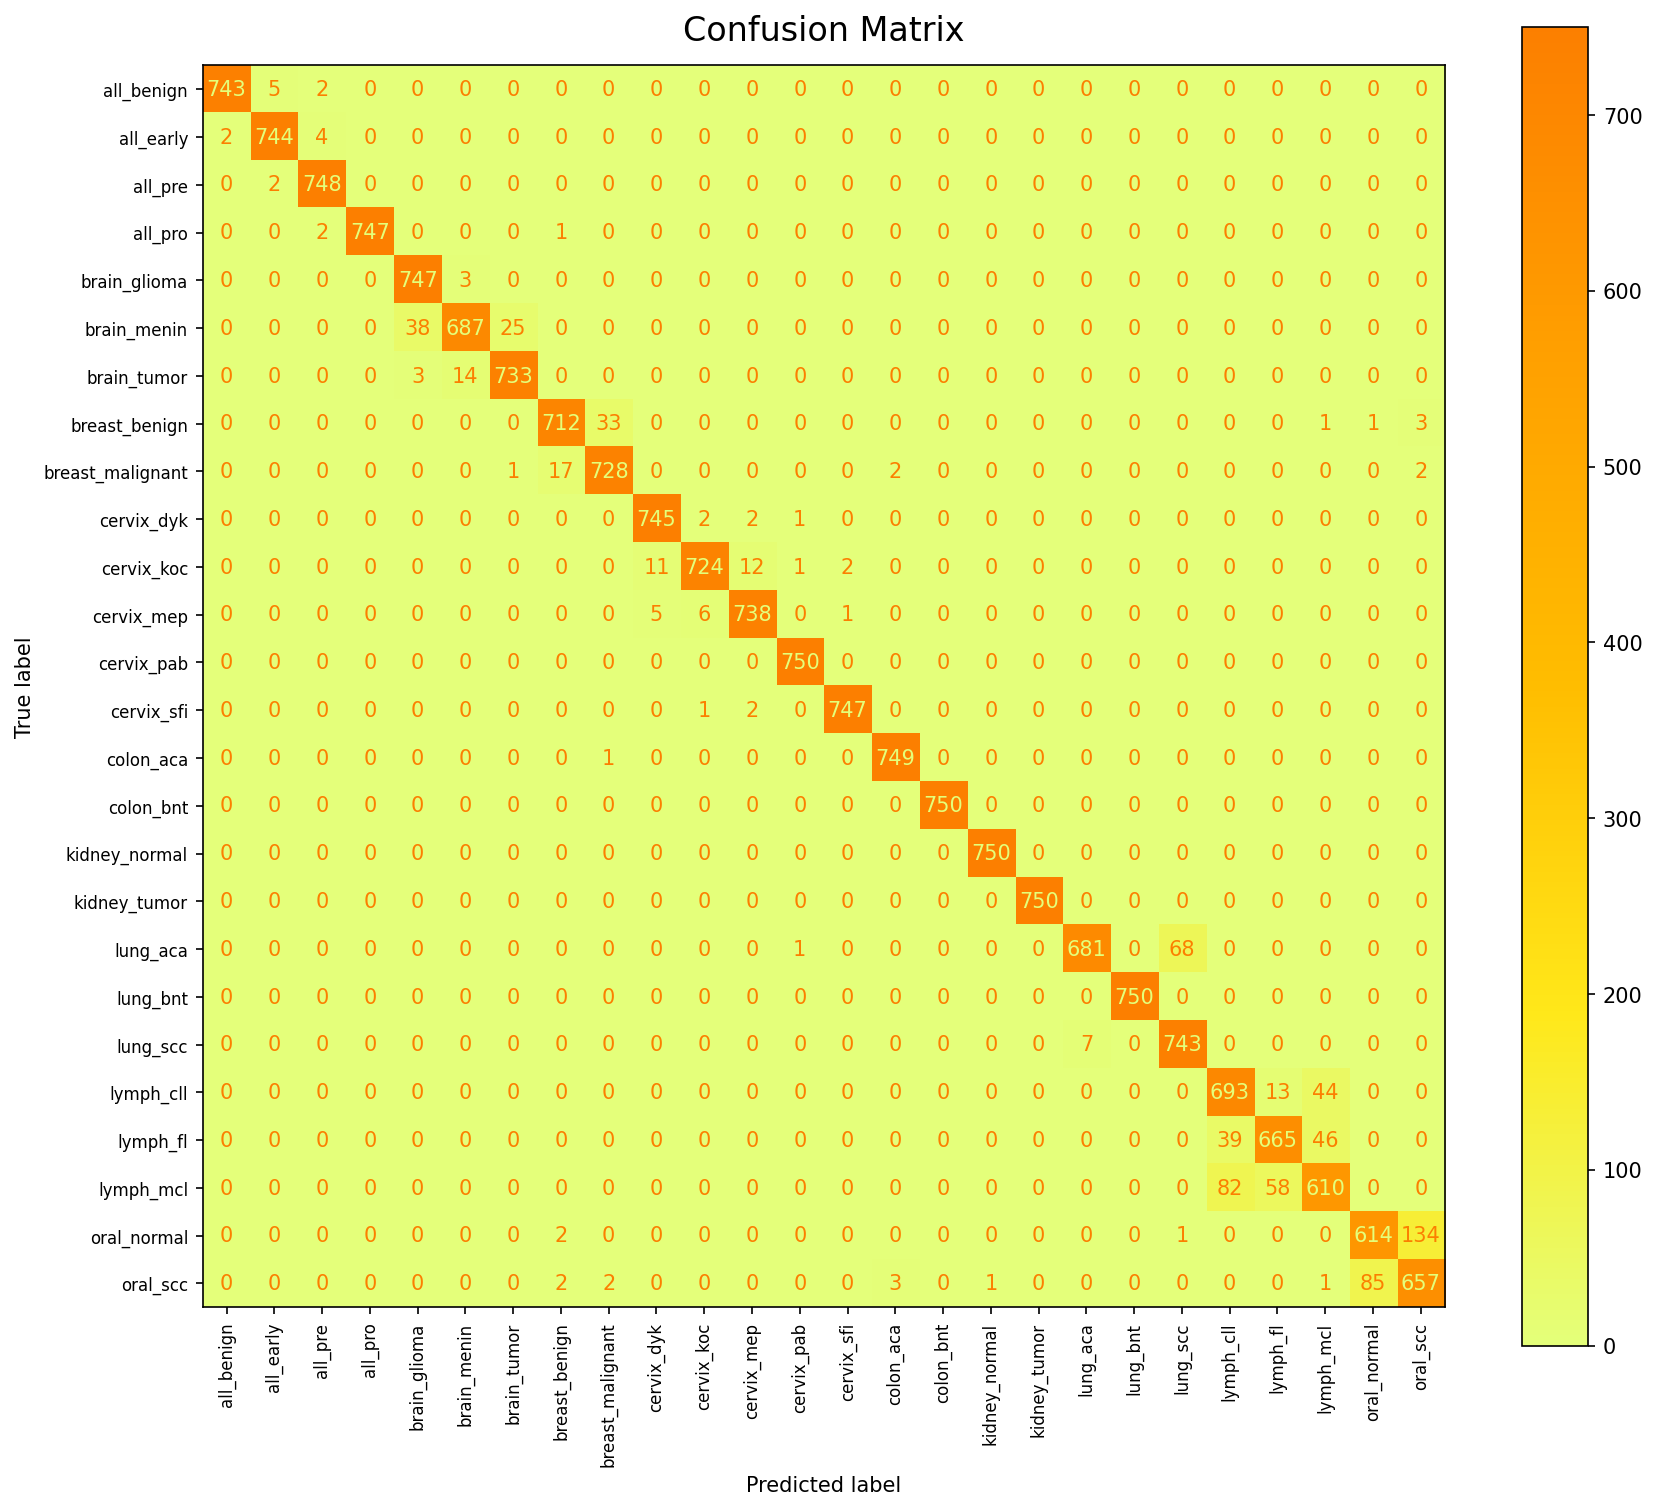

In [19]:
# -----------------------------
# 5. Evaluate
# -----------------------------
test_loss, test_acc = model.evaluate(test_ds, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Acc : {test_acc:.4f}")

y_true_list, y_pred_list = [], []
for images, labels in test_ds:
    preds = model.predict(images, verbose=0)
    y_pred_list.append(np.argmax(preds, axis=1))
    y_true_list.append(labels.numpy())

y_true = np.concatenate(y_true_list)
y_pred = np.concatenate(y_pred_list)

macro_f1 = f1_score(y_true, y_pred, average="macro")
weighted_f1 = f1_score(y_true, y_pred, average="weighted")

print(f"Macro F1   : {macro_f1:.4f}")
print(f"Weighted F1: {weighted_f1:.4f}")
print(classification_report(y_true, y_pred))

# ---- Confusion matrix ----
normalize_cm = None
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

fig, ax = plt.subplots(figsize=(14, 12), dpi=150)

# If you have many classes, annotations can be messy.
# Set include_values=False to make it clean.
disp.plot(
    ax=ax,
    cmap="Wistia",
    include_values=True,  # <-- change to False if still too crowded
    values_format=".2f" if normalize_cm else "d",
    xticks_rotation=90,
    colorbar=True
)

ax.set_title(
    "Confusion Matrix" + (f" (normalize={normalize_cm})" if normalize_cm else ""),
    fontsize=16,
    pad=12
)

# Make tick labels readable
ax.tick_params(axis="x", labelsize=8)
ax.tick_params(axis="y", labelsize=8)

# Give extra room for long x labels
plt.tight_layout()
plt.subplots_adjust(bottom=0.25, left=0.25)

plt.show()
# -----------------------------
# 6. Save model
# -----------------------------
model.save("resnet50v2_functional_headonly.keras")

In [20]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2


In [21]:
# model = tf.keras.models.load_model("/kaggle/working/resnet50v2_functional_headonly.keras")
# model.summary()


In [22]:
# for layer in model.layers:
#     print(layer.name)
# last_conv_layer = model.layers[0].get_layer("conv5_block3_out")
# print(last_conv_layer.output)


In [23]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    # Use the model’s backbone + the classifier head
    grad_model = tf.keras.models.Model(
        [model.input],
        [
            model.get_layer(last_conv_layer_name).output,
            model.output
        ],
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        class_idx = tf.argmax(predictions[0])
        loss = predictions[:, class_idx]

    # Gradient of the top predicted class
    grads = tape.gradient(loss, conv_outputs)

    # Global-average-pool the gradients
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]

    # Multiply each channel by the importance weight
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy(), class_idx.numpy()


In [24]:
def load_and_preprocess(img_path, size=(224, 224)):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = img_array / 255.0
    return img, np.expand_dims(img_array, axis=0)


In [ ]:
def overlay_heatmap(heatmap, image, alpha=0.4):
    heatmap = cv2.resize(heatmap, (image.size[0], image.size[1]))
    heatmap = np.uint8(255 * heatmap)

    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    superimposed_img = cv2.addWeighted(
        cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR),
        1 - alpha,
        heatmap,
        alpha,
        0
    )
    return superimposed_img

In [ ]:
NUM_CLASSES = 26

fig, ax = plt.subplots(NUM_CLASSES, 2, figsize=(8, NUM_CLASSES * 2))

for cls in range(NUM_CLASSES):
    print(f"Processing class {cls}...")

    # find first image of this class
    idx = next(i for i, lab in enumerate(test_labels) if lab == cls)
    img_path = test_paths[idx]

    # load image
    orig_img, img_array = load_and_preprocess(img_path)

    # gradcam
    heatmap, pred_class = make_gradcam_heatmap(
        img_array, model, "conv5_block3_out"
    )
    cam_img = overlay_heatmap(heatmap, orig_img)

    # plot original
    ax[cls, 0].imshow(orig_img)
    ax[cls, 0].axis("off")
    ax[cls, 0].set_title(f"Class {cls} (Original)")

    # plot gradcam
    ax[cls, 1].imshow(cv2.cvtColor(cam_img, cv2.COLOR_BGR2RGB))
    ax[cls, 1].axis("off")
    ax[cls, 1].set_title(f"Grad-CAM (Pred={pred_class})")

plt.tight_layout()
plt.show()